In [1]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *

import logging
from utils import *
set_logger(logging.DEBUG)

In [2]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

In [3]:
import logging
set_logger(logging.DEBUG)

In [4]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
#ds.update_views()

[dp] connect to database postgresql://postgres:@localhost:5432/sdra
[dp] supported views: ['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_transaction_valid']


In [5]:
df_transaction = ds.get_view_df('property_address_transactions')
df_property = ds.get_view_df('property_addresses')
print(df_transaction.shape)
print(df_property.shape)

(1512560, 25)
(709325, 22)


In [6]:
pp = Preprocess(df_transaction, df_property)

In [7]:
pp.get_feature_list()

['date',
 'sqft',
 'num_bed',
 'num_bath',
 'view',
 'pool',
 'sqft_zip_avg',
 'sqft_price_zip_avg',
 'sold_price_zip_avg',
 'impr_over_land',
 'lon',
 'lat']

In [11]:
# records of 5 year
use_features = pp.get_feature_list()
df_track = pp.dataset(feature='delivered', valid=True, date=('2014-10-01', '2017-10-01'))
df_track.shape

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] making prop_count_zip


(100610, 14)

In [9]:
# sanity check
rf = RandomForestRegressor(n_estimators=20, max_depth=10, n_jobs=-1, random_state=17)
mm = ModelManager(df_track[-9291:], ['date']+use_features, rf, time_series=True)
mm.split(test_size=3097, valid_size=3097)

[dp] track/sliding/test window size: 6194, 3097, 3097
[dp] train/valid/test size: 3097, 3097, 3097


In [10]:
# check ModelManager::split does the right order for time-series
print(mm.X_train[:3]['date'])
print(mm.X_train[-3:]['date'])
print(mm.X_val[:3]['date'])
print(mm.X_val[-3:]['date'])
print(mm.X_test[:3]['date'])
print(mm.X_test[-3:]['date'])

            date       date
11455 2017-06-28 2017-06-28
5375  2017-06-28 2017-06-28
5376  2017-06-28 2017-06-28
            date       date
38017 2017-07-27 2017-07-27
38016 2017-07-27 2017-07-27
38015 2017-07-27 2017-07-27
            date       date
17385 2017-07-27 2017-07-27
17387 2017-07-27 2017-07-27
17388 2017-07-27 2017-07-27
            date       date
38078 2017-08-25 2017-08-25
10756 2017-08-25 2017-08-25
10758 2017-08-25 2017-08-25
            date       date
3619  2017-08-25 2017-08-25
39945 2017-08-25 2017-08-25
39946 2017-08-25 2017-08-25
            date       date
20676 2017-09-27 2017-09-27
7091  2017-09-27 2017-09-27
20152 2017-09-27 2017-09-27


### Try RandomForest with different training and testing length
* 5 years(60 months) data is used in total for this validation
* testing length: 1, 2, ..., 6 months
* training: 1, 2, ..., up to 20x of testing length

In [43]:
# total dataset is 3 years = 36 months
# try different testing length: 1-6 months, and training length 1 ~ 20x of testing length
total = df_track.shape[0]
total_months = 36
scores = []
for j in range(1, 7):
    scores.append([])
    num_segment = int(total_months / j)
    for i in range(1, num_segment):
        length_segment = int(total / num_segment)
        use_length = length_segment*(i+2)
        df_train_test = df_track[-use_length:]
        print("use {} months training, {} months testing, total dataset length:{}".format(i*j, j, df_train_test.shape[0]))

        rf = RandomForestRegressor(n_estimators=20, max_depth=10, n_jobs=-1, random_state=17)
        mm = ModelManager(df_train_test, use_features, rf, time_series=True)
        score = mm.run(test_size=length_segment, valid_size=length_segment)
        scores[j-1].append(score)

[dp] track/sliding/test window size: 5588, 2794, 2794
[dp] train/valid/test size: 2794, 2794, 2794
[dp] validation step is skipped


use 1 months training, 1 months testing, total dataset length:8382


[dp] track/sliding/test window size: 8382, 5588, 2794
[dp] train/valid/test size: 5588, 2794, 2794
[dp] validation step is skipped


use 2 months training, 1 months testing, total dataset length:11176


[dp] track/sliding/test window size: 11176, 8382, 2794
[dp] train/valid/test size: 8382, 2794, 2794
[dp] validation step is skipped


use 3 months training, 1 months testing, total dataset length:13970


[dp] track/sliding/test window size: 13970, 11176, 2794
[dp] train/valid/test size: 11176, 2794, 2794
[dp] validation step is skipped


use 4 months training, 1 months testing, total dataset length:16764


[dp] track/sliding/test window size: 16764, 13970, 2794
[dp] train/valid/test size: 13970, 2794, 2794
[dp] validation step is skipped


use 5 months training, 1 months testing, total dataset length:19558


[dp] track/sliding/test window size: 19558, 16764, 2794
[dp] train/valid/test size: 16764, 2794, 2794
[dp] validation step is skipped


use 6 months training, 1 months testing, total dataset length:22352


[dp] track/sliding/test window size: 22352, 19558, 2794
[dp] train/valid/test size: 19558, 2794, 2794
[dp] validation step is skipped


use 7 months training, 1 months testing, total dataset length:25146


[dp] track/sliding/test window size: 25146, 22352, 2794
[dp] train/valid/test size: 22352, 2794, 2794
[dp] validation step is skipped


use 8 months training, 1 months testing, total dataset length:27940


[dp] track/sliding/test window size: 27940, 25146, 2794
[dp] train/valid/test size: 25146, 2794, 2794
[dp] validation step is skipped


use 9 months training, 1 months testing, total dataset length:30734


[dp] track/sliding/test window size: 30734, 27940, 2794
[dp] train/valid/test size: 27940, 2794, 2794
[dp] validation step is skipped


use 10 months training, 1 months testing, total dataset length:33528


[dp] track/sliding/test window size: 33528, 30734, 2794
[dp] train/valid/test size: 30734, 2794, 2794
[dp] validation step is skipped


use 11 months training, 1 months testing, total dataset length:36322


[dp] track/sliding/test window size: 36322, 33528, 2794
[dp] train/valid/test size: 33528, 2794, 2794
[dp] validation step is skipped


use 12 months training, 1 months testing, total dataset length:39116


[dp] track/sliding/test window size: 39116, 36322, 2794
[dp] train/valid/test size: 36322, 2794, 2794
[dp] validation step is skipped


use 13 months training, 1 months testing, total dataset length:41910


[dp] track/sliding/test window size: 41910, 39116, 2794
[dp] train/valid/test size: 39116, 2794, 2794
[dp] validation step is skipped


use 14 months training, 1 months testing, total dataset length:44704


[dp] track/sliding/test window size: 44704, 41910, 2794
[dp] train/valid/test size: 41910, 2794, 2794
[dp] validation step is skipped


use 15 months training, 1 months testing, total dataset length:47498


[dp] track/sliding/test window size: 47498, 44704, 2794
[dp] train/valid/test size: 44704, 2794, 2794
[dp] validation step is skipped


use 16 months training, 1 months testing, total dataset length:50292


[dp] track/sliding/test window size: 50292, 47498, 2794
[dp] train/valid/test size: 47498, 2794, 2794
[dp] validation step is skipped


use 17 months training, 1 months testing, total dataset length:53086


[dp] track/sliding/test window size: 53086, 50292, 2794
[dp] train/valid/test size: 50292, 2794, 2794
[dp] validation step is skipped


use 18 months training, 1 months testing, total dataset length:55880


[dp] track/sliding/test window size: 55880, 53086, 2794
[dp] train/valid/test size: 53086, 2794, 2794
[dp] validation step is skipped


use 19 months training, 1 months testing, total dataset length:58674


[dp] track/sliding/test window size: 58674, 55880, 2794
[dp] train/valid/test size: 55880, 2794, 2794
[dp] validation step is skipped


use 20 months training, 1 months testing, total dataset length:61468


[dp] track/sliding/test window size: 61468, 58674, 2794
[dp] train/valid/test size: 58674, 2794, 2794
[dp] validation step is skipped


use 21 months training, 1 months testing, total dataset length:64262


[dp] track/sliding/test window size: 64262, 61468, 2794
[dp] train/valid/test size: 61468, 2794, 2794
[dp] validation step is skipped


use 22 months training, 1 months testing, total dataset length:67056


[dp] track/sliding/test window size: 67056, 64262, 2794
[dp] train/valid/test size: 64262, 2794, 2794
[dp] validation step is skipped


use 23 months training, 1 months testing, total dataset length:69850


[dp] track/sliding/test window size: 69850, 67056, 2794
[dp] train/valid/test size: 67056, 2794, 2794
[dp] validation step is skipped


use 24 months training, 1 months testing, total dataset length:72644


[dp] track/sliding/test window size: 72644, 69850, 2794
[dp] train/valid/test size: 69850, 2794, 2794
[dp] validation step is skipped


use 25 months training, 1 months testing, total dataset length:75438


[dp] track/sliding/test window size: 75438, 72644, 2794
[dp] train/valid/test size: 72644, 2794, 2794
[dp] validation step is skipped


use 26 months training, 1 months testing, total dataset length:78232


[dp] track/sliding/test window size: 78232, 75438, 2794
[dp] train/valid/test size: 75438, 2794, 2794
[dp] validation step is skipped


use 27 months training, 1 months testing, total dataset length:81026


[dp] track/sliding/test window size: 81026, 78232, 2794
[dp] train/valid/test size: 78232, 2794, 2794
[dp] validation step is skipped


use 28 months training, 1 months testing, total dataset length:83820


[dp] track/sliding/test window size: 83820, 81026, 2794
[dp] train/valid/test size: 81026, 2794, 2794
[dp] validation step is skipped


use 29 months training, 1 months testing, total dataset length:86614


[dp] track/sliding/test window size: 86614, 83820, 2794
[dp] train/valid/test size: 83820, 2794, 2794
[dp] validation step is skipped


use 30 months training, 1 months testing, total dataset length:89408


[dp] track/sliding/test window size: 89408, 86614, 2794
[dp] train/valid/test size: 86614, 2794, 2794
[dp] validation step is skipped


use 31 months training, 1 months testing, total dataset length:92202


[dp] track/sliding/test window size: 92202, 89408, 2794
[dp] train/valid/test size: 89408, 2794, 2794
[dp] validation step is skipped


use 32 months training, 1 months testing, total dataset length:94996


[dp] track/sliding/test window size: 94996, 92202, 2794
[dp] train/valid/test size: 92202, 2794, 2794
[dp] validation step is skipped


use 33 months training, 1 months testing, total dataset length:97790


[dp] track/sliding/test window size: 97790, 94996, 2794
[dp] train/valid/test size: 94996, 2794, 2794
[dp] validation step is skipped


use 34 months training, 1 months testing, total dataset length:100584


[dp] track/sliding/test window size: 97816, 95022, 2794
[dp] train/valid/test size: 95022, 2794, 2794
[dp] validation step is skipped


use 35 months training, 1 months testing, total dataset length:100610


[dp] track/sliding/test window size: 11178, 5589, 5589
[dp] train/valid/test size: 5589, 5589, 5589
[dp] validation step is skipped


use 2 months training, 2 months testing, total dataset length:16767


[dp] track/sliding/test window size: 16767, 11178, 5589
[dp] train/valid/test size: 11178, 5589, 5589
[dp] validation step is skipped


use 4 months training, 2 months testing, total dataset length:22356


[dp] track/sliding/test window size: 22356, 16767, 5589
[dp] train/valid/test size: 16767, 5589, 5589
[dp] validation step is skipped


use 6 months training, 2 months testing, total dataset length:27945


[dp] track/sliding/test window size: 27945, 22356, 5589
[dp] train/valid/test size: 22356, 5589, 5589
[dp] validation step is skipped


use 8 months training, 2 months testing, total dataset length:33534


[dp] track/sliding/test window size: 33534, 27945, 5589
[dp] train/valid/test size: 27945, 5589, 5589
[dp] validation step is skipped


use 10 months training, 2 months testing, total dataset length:39123


[dp] track/sliding/test window size: 39123, 33534, 5589
[dp] train/valid/test size: 33534, 5589, 5589
[dp] validation step is skipped


use 12 months training, 2 months testing, total dataset length:44712


[dp] track/sliding/test window size: 44712, 39123, 5589
[dp] train/valid/test size: 39123, 5589, 5589
[dp] validation step is skipped


use 14 months training, 2 months testing, total dataset length:50301


[dp] track/sliding/test window size: 50301, 44712, 5589
[dp] train/valid/test size: 44712, 5589, 5589
[dp] validation step is skipped


use 16 months training, 2 months testing, total dataset length:55890


[dp] track/sliding/test window size: 55890, 50301, 5589
[dp] train/valid/test size: 50301, 5589, 5589
[dp] validation step is skipped


use 18 months training, 2 months testing, total dataset length:61479


[dp] track/sliding/test window size: 61479, 55890, 5589
[dp] train/valid/test size: 55890, 5589, 5589
[dp] validation step is skipped


use 20 months training, 2 months testing, total dataset length:67068


[dp] track/sliding/test window size: 67068, 61479, 5589
[dp] train/valid/test size: 61479, 5589, 5589
[dp] validation step is skipped


use 22 months training, 2 months testing, total dataset length:72657


[dp] track/sliding/test window size: 72657, 67068, 5589
[dp] train/valid/test size: 67068, 5589, 5589
[dp] validation step is skipped


use 24 months training, 2 months testing, total dataset length:78246


[dp] track/sliding/test window size: 78246, 72657, 5589
[dp] train/valid/test size: 72657, 5589, 5589
[dp] validation step is skipped


use 26 months training, 2 months testing, total dataset length:83835


[dp] track/sliding/test window size: 83835, 78246, 5589
[dp] train/valid/test size: 78246, 5589, 5589
[dp] validation step is skipped


use 28 months training, 2 months testing, total dataset length:89424


[dp] track/sliding/test window size: 89424, 83835, 5589
[dp] train/valid/test size: 83835, 5589, 5589
[dp] validation step is skipped


use 30 months training, 2 months testing, total dataset length:95013


[dp] track/sliding/test window size: 95013, 89424, 5589
[dp] train/valid/test size: 89424, 5589, 5589
[dp] validation step is skipped


use 32 months training, 2 months testing, total dataset length:100602


[dp] track/sliding/test window size: 95021, 89432, 5589
[dp] train/valid/test size: 89432, 5589, 5589
[dp] validation step is skipped


use 34 months training, 2 months testing, total dataset length:100610


[dp] track/sliding/test window size: 16768, 8384, 8384
[dp] train/valid/test size: 8384, 8384, 8384
[dp] validation step is skipped


use 3 months training, 3 months testing, total dataset length:25152


[dp] track/sliding/test window size: 25152, 16768, 8384
[dp] train/valid/test size: 16768, 8384, 8384
[dp] validation step is skipped


use 6 months training, 3 months testing, total dataset length:33536


[dp] track/sliding/test window size: 33536, 25152, 8384
[dp] train/valid/test size: 25152, 8384, 8384
[dp] validation step is skipped


use 9 months training, 3 months testing, total dataset length:41920


[dp] track/sliding/test window size: 41920, 33536, 8384
[dp] train/valid/test size: 33536, 8384, 8384
[dp] validation step is skipped


use 12 months training, 3 months testing, total dataset length:50304


[dp] track/sliding/test window size: 50304, 41920, 8384
[dp] train/valid/test size: 41920, 8384, 8384
[dp] validation step is skipped


use 15 months training, 3 months testing, total dataset length:58688


[dp] track/sliding/test window size: 58688, 50304, 8384
[dp] train/valid/test size: 50304, 8384, 8384
[dp] validation step is skipped


use 18 months training, 3 months testing, total dataset length:67072


[dp] track/sliding/test window size: 67072, 58688, 8384
[dp] train/valid/test size: 58688, 8384, 8384
[dp] validation step is skipped


use 21 months training, 3 months testing, total dataset length:75456


[dp] track/sliding/test window size: 75456, 67072, 8384
[dp] train/valid/test size: 67072, 8384, 8384
[dp] validation step is skipped


use 24 months training, 3 months testing, total dataset length:83840


[dp] track/sliding/test window size: 83840, 75456, 8384
[dp] train/valid/test size: 75456, 8384, 8384
[dp] validation step is skipped


use 27 months training, 3 months testing, total dataset length:92224


[dp] track/sliding/test window size: 92224, 83840, 8384
[dp] train/valid/test size: 83840, 8384, 8384
[dp] validation step is skipped


use 30 months training, 3 months testing, total dataset length:100608


[dp] track/sliding/test window size: 92226, 83842, 8384
[dp] train/valid/test size: 83842, 8384, 8384
[dp] validation step is skipped


use 33 months training, 3 months testing, total dataset length:100610


[dp] track/sliding/test window size: 22356, 11178, 11178
[dp] train/valid/test size: 11178, 11178, 11178
[dp] validation step is skipped


use 4 months training, 4 months testing, total dataset length:33534


[dp] track/sliding/test window size: 33534, 22356, 11178
[dp] train/valid/test size: 22356, 11178, 11178
[dp] validation step is skipped


use 8 months training, 4 months testing, total dataset length:44712


[dp] track/sliding/test window size: 44712, 33534, 11178
[dp] train/valid/test size: 33534, 11178, 11178
[dp] validation step is skipped


use 12 months training, 4 months testing, total dataset length:55890


[dp] track/sliding/test window size: 55890, 44712, 11178
[dp] train/valid/test size: 44712, 11178, 11178
[dp] validation step is skipped


use 16 months training, 4 months testing, total dataset length:67068


[dp] track/sliding/test window size: 67068, 55890, 11178
[dp] train/valid/test size: 55890, 11178, 11178
[dp] validation step is skipped


use 20 months training, 4 months testing, total dataset length:78246


[dp] track/sliding/test window size: 78246, 67068, 11178
[dp] train/valid/test size: 67068, 11178, 11178
[dp] validation step is skipped


use 24 months training, 4 months testing, total dataset length:89424


[dp] track/sliding/test window size: 89424, 78246, 11178
[dp] train/valid/test size: 78246, 11178, 11178
[dp] validation step is skipped


use 28 months training, 4 months testing, total dataset length:100602


[dp] track/sliding/test window size: 89432, 78254, 11178
[dp] train/valid/test size: 78254, 11178, 11178
[dp] validation step is skipped


use 32 months training, 4 months testing, total dataset length:100610


[dp] track/sliding/test window size: 28744, 14372, 14372
[dp] train/valid/test size: 14372, 14372, 14372
[dp] validation step is skipped


use 5 months training, 5 months testing, total dataset length:43116


[dp] track/sliding/test window size: 43116, 28744, 14372
[dp] train/valid/test size: 28744, 14372, 14372
[dp] validation step is skipped


use 10 months training, 5 months testing, total dataset length:57488


[dp] track/sliding/test window size: 57488, 43116, 14372
[dp] train/valid/test size: 43116, 14372, 14372
[dp] validation step is skipped


use 15 months training, 5 months testing, total dataset length:71860


[dp] track/sliding/test window size: 71860, 57488, 14372
[dp] train/valid/test size: 57488, 14372, 14372
[dp] validation step is skipped


use 20 months training, 5 months testing, total dataset length:86232


[dp] track/sliding/test window size: 86232, 71860, 14372
[dp] train/valid/test size: 71860, 14372, 14372
[dp] validation step is skipped


use 25 months training, 5 months testing, total dataset length:100604


[dp] track/sliding/test window size: 86238, 71866, 14372
[dp] train/valid/test size: 71866, 14372, 14372
[dp] validation step is skipped


use 30 months training, 5 months testing, total dataset length:100610


[dp] track/sliding/test window size: 33536, 16768, 16768
[dp] train/valid/test size: 16768, 16768, 16768
[dp] validation step is skipped


use 6 months training, 6 months testing, total dataset length:50304


[dp] track/sliding/test window size: 50304, 33536, 16768
[dp] train/valid/test size: 33536, 16768, 16768
[dp] validation step is skipped


use 12 months training, 6 months testing, total dataset length:67072


[dp] track/sliding/test window size: 67072, 50304, 16768
[dp] train/valid/test size: 50304, 16768, 16768
[dp] validation step is skipped


use 18 months training, 6 months testing, total dataset length:83840


[dp] track/sliding/test window size: 83840, 67072, 16768
[dp] train/valid/test size: 67072, 16768, 16768
[dp] validation step is skipped


use 24 months training, 6 months testing, total dataset length:100608


[dp] track/sliding/test window size: 83842, 67074, 16768
[dp] train/valid/test size: 67074, 16768, 16768
[dp] validation step is skipped


use 30 months training, 6 months testing, total dataset length:100610


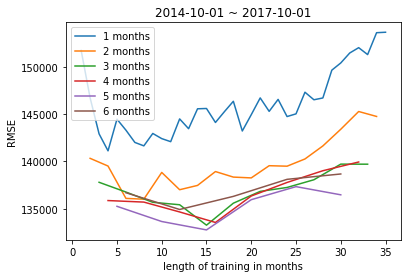

In [44]:
fig=plt.figure()
for j in range(1, 7):
    num_segment = int(total_months / j)
    x = [i*j for i in range(1, num_segment)]
    plt.plot(x, scores[j-1], label='{} months'.format(j))

plt.title('2014-10-01 ~ 2017-10-01')
plt.xlabel("length of training in months")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [45]:
### debug why 1month test has that poor performance
### pick the point of 15-month training to compare between 1month testing and 4months testing
df_debug = pp.dataset(feature='delivered', valid=True, date=('2014-10-01', '2017-10-01'))

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] making prop_count_zip


In [38]:
total = df_debug.shape[0]
j = 1
total_months = 36
montly = int(total / total_months)

use_length = monthly*17
df_train_test = df_debug[-use_length:]
rf = RandomForestRegressor(n_estimators=20, max_depth=10, n_jobs=-1, random_state=17)
mm = ModelManager(df_train_test, use_features, rf, time_series=True)
score = mm.run(test_size=length_segment, valid_size=length_segment)
score

[dp] track/sliding/test window size: 44704, 41910, 2794
[dp] train/valid/test size: 41910, 2794, 2794
[dp] validation step is skipped


145590.6454696371

In [27]:
length_segment = monthly*4
use_length = length_segment*6
df_train_test = df_debug[-use_length:]

rf = RandomForestRegressor(n_estimators=20, max_depth=10, n_jobs=-1, random_state=17)
mm1 = ModelManager(df_train_test, use_features, rf, time_series=True)
score = mm1.run(test_size=length_segment, valid_size=length_segment)

[dp] track/sliding/test window size: 55890, 44712, 11178
[dp] train/valid/test size: 44712, 11178, 11178
[dp] validation step is skipped


In [42]:
df_result = mm1.get_result_df()
df_last = df_result[-monthly:]
sqrt(mean_squared_error(df_last['predict'], df_last['sold_price']))

148460.50513762012

In [41]:
# now we can see, the 4 months testing doesn't perform better than 1month on predicting the last month
# so the poor performance of 1month-testing is due to high variance in data, probably due to outliers in last month
# suggest we need go back to do more cleaning on data

148460.50513762012

### conclusion
* testing size of 1 or 2 months is a little too small and model performance is not very stable
* testing size of >= 3 looks similar
* training length has elbow point at around 10~15 months
* let's try testing length: 4, training: 12

In [17]:
### redo for 2003~2008
df_track1 = pp.dataset(feature='delivered', valid=True, date=('2003-01-01', '2006-01-01'))
print(df_track1.shape)

# total dataset is 3 years = 36 months
# try different testing length: 1-6 months, and training length 1 ~ 20x of testing length
total = df_track1.shape[0]
total_months = 36
scores = []
for j in range(1, 7):
    scores.append([])
    num_segment = int(total_months / j)
    for i in range(1, num_segment):
        length_segment = int(total / num_segment)
        use_length = length_segment*(i+2)
        df_train_test = df_track1[-use_length:]
        print("use {} months training, {} months testing, total dataset length:{}".format(i*j, j, df_train_test.shape[0]))

        rf = RandomForestRegressor(n_estimators=20, max_depth=10, n_jobs=-1, random_state=17)
        mm = ModelManager(df_train_test, use_features, rf, time_series=True)
        score = mm.run(test_size=length_segment, valid_size=length_segment)
        scores[j-1].append(score)

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] making prop_count_zip
[dp] track/sliding/test window size: 9342, 4671, 4671
[dp] train/valid/test size: 4671, 4671, 4671
[dp] validation step is skipped


(168169, 14)
use 1 months training, 1 months testing, total dataset length:14013


[dp] track/sliding/test window size: 14013, 9342, 4671
[dp] train/valid/test size: 9342, 4671, 4671
[dp] validation step is skipped


use 2 months training, 1 months testing, total dataset length:18684


[dp] track/sliding/test window size: 18684, 14013, 4671
[dp] train/valid/test size: 14013, 4671, 4671
[dp] validation step is skipped


use 3 months training, 1 months testing, total dataset length:23355


[dp] track/sliding/test window size: 23355, 18684, 4671
[dp] train/valid/test size: 18684, 4671, 4671
[dp] validation step is skipped


use 4 months training, 1 months testing, total dataset length:28026


[dp] track/sliding/test window size: 28026, 23355, 4671
[dp] train/valid/test size: 23355, 4671, 4671
[dp] validation step is skipped


use 5 months training, 1 months testing, total dataset length:32697


[dp] track/sliding/test window size: 32697, 28026, 4671
[dp] train/valid/test size: 28026, 4671, 4671
[dp] validation step is skipped


use 6 months training, 1 months testing, total dataset length:37368


[dp] track/sliding/test window size: 37368, 32697, 4671
[dp] train/valid/test size: 32697, 4671, 4671
[dp] validation step is skipped


use 7 months training, 1 months testing, total dataset length:42039


[dp] track/sliding/test window size: 42039, 37368, 4671
[dp] train/valid/test size: 37368, 4671, 4671
[dp] validation step is skipped


use 8 months training, 1 months testing, total dataset length:46710


[dp] track/sliding/test window size: 46710, 42039, 4671
[dp] train/valid/test size: 42039, 4671, 4671
[dp] validation step is skipped


use 9 months training, 1 months testing, total dataset length:51381


[dp] track/sliding/test window size: 51381, 46710, 4671
[dp] train/valid/test size: 46710, 4671, 4671
[dp] validation step is skipped


use 10 months training, 1 months testing, total dataset length:56052


[dp] track/sliding/test window size: 56052, 51381, 4671
[dp] train/valid/test size: 51381, 4671, 4671
[dp] validation step is skipped


use 11 months training, 1 months testing, total dataset length:60723


[dp] track/sliding/test window size: 60723, 56052, 4671
[dp] train/valid/test size: 56052, 4671, 4671
[dp] validation step is skipped


use 12 months training, 1 months testing, total dataset length:65394


[dp] track/sliding/test window size: 65394, 60723, 4671
[dp] train/valid/test size: 60723, 4671, 4671
[dp] validation step is skipped


use 13 months training, 1 months testing, total dataset length:70065


[dp] track/sliding/test window size: 70065, 65394, 4671
[dp] train/valid/test size: 65394, 4671, 4671
[dp] validation step is skipped


use 14 months training, 1 months testing, total dataset length:74736


[dp] track/sliding/test window size: 74736, 70065, 4671
[dp] train/valid/test size: 70065, 4671, 4671
[dp] validation step is skipped


use 15 months training, 1 months testing, total dataset length:79407


[dp] track/sliding/test window size: 79407, 74736, 4671
[dp] train/valid/test size: 74736, 4671, 4671
[dp] validation step is skipped


use 16 months training, 1 months testing, total dataset length:84078


[dp] track/sliding/test window size: 84078, 79407, 4671
[dp] train/valid/test size: 79407, 4671, 4671
[dp] validation step is skipped


use 17 months training, 1 months testing, total dataset length:88749


[dp] track/sliding/test window size: 88749, 84078, 4671
[dp] train/valid/test size: 84078, 4671, 4671
[dp] validation step is skipped


use 18 months training, 1 months testing, total dataset length:93420


[dp] track/sliding/test window size: 93420, 88749, 4671
[dp] train/valid/test size: 88749, 4671, 4671
[dp] validation step is skipped


use 19 months training, 1 months testing, total dataset length:98091


[dp] track/sliding/test window size: 98091, 93420, 4671
[dp] train/valid/test size: 93420, 4671, 4671
[dp] validation step is skipped


use 20 months training, 1 months testing, total dataset length:102762


[dp] track/sliding/test window size: 102762, 98091, 4671
[dp] train/valid/test size: 98091, 4671, 4671
[dp] validation step is skipped


use 21 months training, 1 months testing, total dataset length:107433


[dp] track/sliding/test window size: 107433, 102762, 4671
[dp] train/valid/test size: 102762, 4671, 4671
[dp] validation step is skipped


use 22 months training, 1 months testing, total dataset length:112104


[dp] track/sliding/test window size: 112104, 107433, 4671
[dp] train/valid/test size: 107433, 4671, 4671
[dp] validation step is skipped


use 23 months training, 1 months testing, total dataset length:116775


[dp] track/sliding/test window size: 116775, 112104, 4671
[dp] train/valid/test size: 112104, 4671, 4671
[dp] validation step is skipped


use 24 months training, 1 months testing, total dataset length:121446


[dp] track/sliding/test window size: 121446, 116775, 4671
[dp] train/valid/test size: 116775, 4671, 4671
[dp] validation step is skipped


use 25 months training, 1 months testing, total dataset length:126117


[dp] track/sliding/test window size: 126117, 121446, 4671
[dp] train/valid/test size: 121446, 4671, 4671
[dp] validation step is skipped


use 26 months training, 1 months testing, total dataset length:130788


[dp] track/sliding/test window size: 130788, 126117, 4671
[dp] train/valid/test size: 126117, 4671, 4671
[dp] validation step is skipped


use 27 months training, 1 months testing, total dataset length:135459


[dp] track/sliding/test window size: 135459, 130788, 4671
[dp] train/valid/test size: 130788, 4671, 4671
[dp] validation step is skipped


use 28 months training, 1 months testing, total dataset length:140130


[dp] track/sliding/test window size: 140130, 135459, 4671
[dp] train/valid/test size: 135459, 4671, 4671
[dp] validation step is skipped


use 29 months training, 1 months testing, total dataset length:144801


[dp] track/sliding/test window size: 144801, 140130, 4671
[dp] train/valid/test size: 140130, 4671, 4671
[dp] validation step is skipped


use 30 months training, 1 months testing, total dataset length:149472


[dp] track/sliding/test window size: 149472, 144801, 4671
[dp] train/valid/test size: 144801, 4671, 4671
[dp] validation step is skipped


use 31 months training, 1 months testing, total dataset length:154143


[dp] track/sliding/test window size: 154143, 149472, 4671
[dp] train/valid/test size: 149472, 4671, 4671
[dp] validation step is skipped


use 32 months training, 1 months testing, total dataset length:158814


[dp] track/sliding/test window size: 158814, 154143, 4671
[dp] train/valid/test size: 154143, 4671, 4671
[dp] validation step is skipped


use 33 months training, 1 months testing, total dataset length:163485


[dp] track/sliding/test window size: 163485, 158814, 4671
[dp] train/valid/test size: 158814, 4671, 4671
[dp] validation step is skipped


use 34 months training, 1 months testing, total dataset length:168156


[dp] track/sliding/test window size: 163498, 158827, 4671
[dp] train/valid/test size: 158827, 4671, 4671
[dp] validation step is skipped


use 35 months training, 1 months testing, total dataset length:168169


[dp] track/sliding/test window size: 18684, 9342, 9342
[dp] train/valid/test size: 9342, 9342, 9342
[dp] validation step is skipped


use 2 months training, 2 months testing, total dataset length:28026


[dp] track/sliding/test window size: 28026, 18684, 9342
[dp] train/valid/test size: 18684, 9342, 9342
[dp] validation step is skipped


use 4 months training, 2 months testing, total dataset length:37368


[dp] track/sliding/test window size: 37368, 28026, 9342
[dp] train/valid/test size: 28026, 9342, 9342
[dp] validation step is skipped


use 6 months training, 2 months testing, total dataset length:46710


[dp] track/sliding/test window size: 46710, 37368, 9342
[dp] train/valid/test size: 37368, 9342, 9342
[dp] validation step is skipped


use 8 months training, 2 months testing, total dataset length:56052


[dp] track/sliding/test window size: 56052, 46710, 9342
[dp] train/valid/test size: 46710, 9342, 9342
[dp] validation step is skipped


use 10 months training, 2 months testing, total dataset length:65394


[dp] track/sliding/test window size: 65394, 56052, 9342
[dp] train/valid/test size: 56052, 9342, 9342
[dp] validation step is skipped


use 12 months training, 2 months testing, total dataset length:74736


[dp] track/sliding/test window size: 74736, 65394, 9342
[dp] train/valid/test size: 65394, 9342, 9342
[dp] validation step is skipped


use 14 months training, 2 months testing, total dataset length:84078


[dp] track/sliding/test window size: 84078, 74736, 9342
[dp] train/valid/test size: 74736, 9342, 9342
[dp] validation step is skipped


use 16 months training, 2 months testing, total dataset length:93420


[dp] track/sliding/test window size: 93420, 84078, 9342
[dp] train/valid/test size: 84078, 9342, 9342
[dp] validation step is skipped


use 18 months training, 2 months testing, total dataset length:102762


[dp] track/sliding/test window size: 102762, 93420, 9342
[dp] train/valid/test size: 93420, 9342, 9342
[dp] validation step is skipped


use 20 months training, 2 months testing, total dataset length:112104


[dp] track/sliding/test window size: 112104, 102762, 9342
[dp] train/valid/test size: 102762, 9342, 9342
[dp] validation step is skipped


use 22 months training, 2 months testing, total dataset length:121446


[dp] track/sliding/test window size: 121446, 112104, 9342
[dp] train/valid/test size: 112104, 9342, 9342
[dp] validation step is skipped


use 24 months training, 2 months testing, total dataset length:130788


[dp] track/sliding/test window size: 130788, 121446, 9342
[dp] train/valid/test size: 121446, 9342, 9342
[dp] validation step is skipped


use 26 months training, 2 months testing, total dataset length:140130


[dp] track/sliding/test window size: 140130, 130788, 9342
[dp] train/valid/test size: 130788, 9342, 9342
[dp] validation step is skipped


use 28 months training, 2 months testing, total dataset length:149472


[dp] track/sliding/test window size: 149472, 140130, 9342
[dp] train/valid/test size: 140130, 9342, 9342
[dp] validation step is skipped


use 30 months training, 2 months testing, total dataset length:158814


[dp] track/sliding/test window size: 158814, 149472, 9342
[dp] train/valid/test size: 149472, 9342, 9342
[dp] validation step is skipped


use 32 months training, 2 months testing, total dataset length:168156


[dp] track/sliding/test window size: 158827, 149485, 9342
[dp] train/valid/test size: 149485, 9342, 9342
[dp] validation step is skipped


use 34 months training, 2 months testing, total dataset length:168169


[dp] track/sliding/test window size: 28028, 14014, 14014
[dp] train/valid/test size: 14014, 14014, 14014
[dp] validation step is skipped


use 3 months training, 3 months testing, total dataset length:42042


[dp] track/sliding/test window size: 42042, 28028, 14014
[dp] train/valid/test size: 28028, 14014, 14014
[dp] validation step is skipped


use 6 months training, 3 months testing, total dataset length:56056


[dp] track/sliding/test window size: 56056, 42042, 14014
[dp] train/valid/test size: 42042, 14014, 14014
[dp] validation step is skipped


use 9 months training, 3 months testing, total dataset length:70070


[dp] track/sliding/test window size: 70070, 56056, 14014
[dp] train/valid/test size: 56056, 14014, 14014
[dp] validation step is skipped


use 12 months training, 3 months testing, total dataset length:84084


[dp] track/sliding/test window size: 84084, 70070, 14014
[dp] train/valid/test size: 70070, 14014, 14014
[dp] validation step is skipped


use 15 months training, 3 months testing, total dataset length:98098


[dp] track/sliding/test window size: 98098, 84084, 14014
[dp] train/valid/test size: 84084, 14014, 14014
[dp] validation step is skipped


use 18 months training, 3 months testing, total dataset length:112112


[dp] track/sliding/test window size: 112112, 98098, 14014
[dp] train/valid/test size: 98098, 14014, 14014
[dp] validation step is skipped


use 21 months training, 3 months testing, total dataset length:126126


[dp] track/sliding/test window size: 126126, 112112, 14014
[dp] train/valid/test size: 112112, 14014, 14014
[dp] validation step is skipped


use 24 months training, 3 months testing, total dataset length:140140


[dp] track/sliding/test window size: 140140, 126126, 14014
[dp] train/valid/test size: 126126, 14014, 14014
[dp] validation step is skipped


use 27 months training, 3 months testing, total dataset length:154154


[dp] track/sliding/test window size: 154154, 140140, 14014
[dp] train/valid/test size: 140140, 14014, 14014
[dp] validation step is skipped


use 30 months training, 3 months testing, total dataset length:168168


[dp] track/sliding/test window size: 154155, 140141, 14014
[dp] train/valid/test size: 140141, 14014, 14014
[dp] validation step is skipped


use 33 months training, 3 months testing, total dataset length:168169


[dp] track/sliding/test window size: 37370, 18685, 18685
[dp] train/valid/test size: 18685, 18685, 18685
[dp] validation step is skipped


use 4 months training, 4 months testing, total dataset length:56055


[dp] track/sliding/test window size: 56055, 37370, 18685
[dp] train/valid/test size: 37370, 18685, 18685
[dp] validation step is skipped


use 8 months training, 4 months testing, total dataset length:74740


[dp] track/sliding/test window size: 74740, 56055, 18685
[dp] train/valid/test size: 56055, 18685, 18685
[dp] validation step is skipped


use 12 months training, 4 months testing, total dataset length:93425


[dp] track/sliding/test window size: 93425, 74740, 18685
[dp] train/valid/test size: 74740, 18685, 18685
[dp] validation step is skipped


use 16 months training, 4 months testing, total dataset length:112110


[dp] track/sliding/test window size: 112110, 93425, 18685
[dp] train/valid/test size: 93425, 18685, 18685
[dp] validation step is skipped


use 20 months training, 4 months testing, total dataset length:130795


[dp] track/sliding/test window size: 130795, 112110, 18685
[dp] train/valid/test size: 112110, 18685, 18685
[dp] validation step is skipped


use 24 months training, 4 months testing, total dataset length:149480


[dp] track/sliding/test window size: 149480, 130795, 18685
[dp] train/valid/test size: 130795, 18685, 18685
[dp] validation step is skipped


use 28 months training, 4 months testing, total dataset length:168165


[dp] track/sliding/test window size: 149484, 130799, 18685
[dp] train/valid/test size: 130799, 18685, 18685
[dp] validation step is skipped


use 32 months training, 4 months testing, total dataset length:168169


[dp] track/sliding/test window size: 48048, 24024, 24024
[dp] train/valid/test size: 24024, 24024, 24024
[dp] validation step is skipped


use 5 months training, 5 months testing, total dataset length:72072


[dp] track/sliding/test window size: 72072, 48048, 24024
[dp] train/valid/test size: 48048, 24024, 24024
[dp] validation step is skipped


use 10 months training, 5 months testing, total dataset length:96096


[dp] track/sliding/test window size: 96096, 72072, 24024
[dp] train/valid/test size: 72072, 24024, 24024
[dp] validation step is skipped


use 15 months training, 5 months testing, total dataset length:120120


[dp] track/sliding/test window size: 120120, 96096, 24024
[dp] train/valid/test size: 96096, 24024, 24024
[dp] validation step is skipped


use 20 months training, 5 months testing, total dataset length:144144


[dp] track/sliding/test window size: 144144, 120120, 24024
[dp] train/valid/test size: 120120, 24024, 24024
[dp] validation step is skipped


use 25 months training, 5 months testing, total dataset length:168168


[dp] track/sliding/test window size: 144145, 120121, 24024
[dp] train/valid/test size: 120121, 24024, 24024
[dp] validation step is skipped


use 30 months training, 5 months testing, total dataset length:168169


[dp] track/sliding/test window size: 56056, 28028, 28028
[dp] train/valid/test size: 28028, 28028, 28028
[dp] validation step is skipped


use 6 months training, 6 months testing, total dataset length:84084


[dp] track/sliding/test window size: 84084, 56056, 28028
[dp] train/valid/test size: 56056, 28028, 28028
[dp] validation step is skipped


use 12 months training, 6 months testing, total dataset length:112112


[dp] track/sliding/test window size: 112112, 84084, 28028
[dp] train/valid/test size: 84084, 28028, 28028
[dp] validation step is skipped


use 18 months training, 6 months testing, total dataset length:140140


[dp] track/sliding/test window size: 140140, 112112, 28028
[dp] train/valid/test size: 112112, 28028, 28028
[dp] validation step is skipped


use 24 months training, 6 months testing, total dataset length:168168


[dp] track/sliding/test window size: 140141, 112113, 28028
[dp] train/valid/test size: 112113, 28028, 28028
[dp] validation step is skipped


use 30 months training, 6 months testing, total dataset length:168169


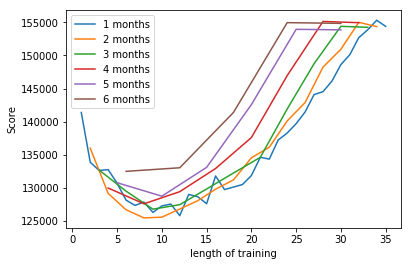

best training length for 2 months testing set is 8


In [18]:
fig=plt.figure()
for j in range(1, 7):
    num_segment = int(total_months / j)
    x = [i*j for i in range(1, num_segment)]
    plt.plot(x, scores[j-1], label='{} months'.format(j))

plt.title('2003-01-01 ~ 2006-01-01')
plt.xlabel("length of training in months")
plt.ylabel("RMSE")
plt.legend()
plt.show()

print('best training length for 2 months testing set is {}'.format((np.argmin(scores)+1)*2))

In [22]:
### redo for 2008~2011
df_track2 = pp.dataset(feature='delivered', valid=True, date=('2008-01-01', '2012-01-01'))
print(df_track2.shape)

# total dataset is 5 years = 60 months
# try different testing length: 1-6 months, and training length 1 ~ 20x of testing length
total = df_track2.shape[0]
total_months = 48
scores = []
for j in range(1, 7):
    scores.append([])
    num_segment = int(total_months / j)
    for i in range(1, num_segment):
        length_segment = int(total / num_segment)
        use_length = length_segment*(i+2)
        df_train_test = df_track2[-use_length:]
        print("use {} months training, {} months testing, total dataset length:{}".format(i*j, j, df_train_test.shape[0]))

        rf = RandomForestRegressor(n_estimators=20, max_depth=10, n_jobs=-1, random_state=17)
        mm = ModelManager(df_train_test, use_features, rf, time_series=True)
        score = mm.run(test_size=length_segment, valid_size=length_segment)
        scores[j-1].append(score)

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] making prop_count_zip
[dp] track/sliding/test window size: 5362, 2681, 2681
[dp] train/valid/test size: 2681, 2681, 2681
[dp] validation step is skipped


(128699, 14)
use 1 months training, 1 months testing, total dataset length:8043


[dp] track/sliding/test window size: 8043, 5362, 2681
[dp] train/valid/test size: 5362, 2681, 2681
[dp] validation step is skipped


use 2 months training, 1 months testing, total dataset length:10724


[dp] track/sliding/test window size: 10724, 8043, 2681
[dp] train/valid/test size: 8043, 2681, 2681
[dp] validation step is skipped


use 3 months training, 1 months testing, total dataset length:13405


[dp] track/sliding/test window size: 13405, 10724, 2681
[dp] train/valid/test size: 10724, 2681, 2681
[dp] validation step is skipped


use 4 months training, 1 months testing, total dataset length:16086


[dp] track/sliding/test window size: 16086, 13405, 2681
[dp] train/valid/test size: 13405, 2681, 2681
[dp] validation step is skipped


use 5 months training, 1 months testing, total dataset length:18767


[dp] track/sliding/test window size: 18767, 16086, 2681
[dp] train/valid/test size: 16086, 2681, 2681
[dp] validation step is skipped


use 6 months training, 1 months testing, total dataset length:21448


[dp] track/sliding/test window size: 21448, 18767, 2681
[dp] train/valid/test size: 18767, 2681, 2681
[dp] validation step is skipped


use 7 months training, 1 months testing, total dataset length:24129


[dp] track/sliding/test window size: 24129, 21448, 2681
[dp] train/valid/test size: 21448, 2681, 2681
[dp] validation step is skipped


use 8 months training, 1 months testing, total dataset length:26810


[dp] track/sliding/test window size: 26810, 24129, 2681
[dp] train/valid/test size: 24129, 2681, 2681
[dp] validation step is skipped


use 9 months training, 1 months testing, total dataset length:29491


[dp] track/sliding/test window size: 29491, 26810, 2681
[dp] train/valid/test size: 26810, 2681, 2681
[dp] validation step is skipped


use 10 months training, 1 months testing, total dataset length:32172


[dp] track/sliding/test window size: 32172, 29491, 2681
[dp] train/valid/test size: 29491, 2681, 2681
[dp] validation step is skipped


use 11 months training, 1 months testing, total dataset length:34853


[dp] track/sliding/test window size: 34853, 32172, 2681
[dp] train/valid/test size: 32172, 2681, 2681
[dp] validation step is skipped


use 12 months training, 1 months testing, total dataset length:37534


[dp] track/sliding/test window size: 37534, 34853, 2681
[dp] train/valid/test size: 34853, 2681, 2681
[dp] validation step is skipped


use 13 months training, 1 months testing, total dataset length:40215


[dp] track/sliding/test window size: 40215, 37534, 2681
[dp] train/valid/test size: 37534, 2681, 2681
[dp] validation step is skipped


use 14 months training, 1 months testing, total dataset length:42896


[dp] track/sliding/test window size: 42896, 40215, 2681
[dp] train/valid/test size: 40215, 2681, 2681
[dp] validation step is skipped


use 15 months training, 1 months testing, total dataset length:45577


[dp] track/sliding/test window size: 45577, 42896, 2681
[dp] train/valid/test size: 42896, 2681, 2681
[dp] validation step is skipped


use 16 months training, 1 months testing, total dataset length:48258


[dp] track/sliding/test window size: 48258, 45577, 2681
[dp] train/valid/test size: 45577, 2681, 2681
[dp] validation step is skipped


use 17 months training, 1 months testing, total dataset length:50939


[dp] track/sliding/test window size: 50939, 48258, 2681
[dp] train/valid/test size: 48258, 2681, 2681
[dp] validation step is skipped


use 18 months training, 1 months testing, total dataset length:53620


[dp] track/sliding/test window size: 53620, 50939, 2681
[dp] train/valid/test size: 50939, 2681, 2681
[dp] validation step is skipped


use 19 months training, 1 months testing, total dataset length:56301


[dp] track/sliding/test window size: 56301, 53620, 2681
[dp] train/valid/test size: 53620, 2681, 2681
[dp] validation step is skipped


use 20 months training, 1 months testing, total dataset length:58982


[dp] track/sliding/test window size: 58982, 56301, 2681
[dp] train/valid/test size: 56301, 2681, 2681
[dp] validation step is skipped


use 21 months training, 1 months testing, total dataset length:61663


[dp] track/sliding/test window size: 61663, 58982, 2681
[dp] train/valid/test size: 58982, 2681, 2681
[dp] validation step is skipped


use 22 months training, 1 months testing, total dataset length:64344


[dp] track/sliding/test window size: 64344, 61663, 2681
[dp] train/valid/test size: 61663, 2681, 2681
[dp] validation step is skipped


use 23 months training, 1 months testing, total dataset length:67025


[dp] track/sliding/test window size: 67025, 64344, 2681
[dp] train/valid/test size: 64344, 2681, 2681
[dp] validation step is skipped


use 24 months training, 1 months testing, total dataset length:69706


[dp] track/sliding/test window size: 69706, 67025, 2681
[dp] train/valid/test size: 67025, 2681, 2681
[dp] validation step is skipped


use 25 months training, 1 months testing, total dataset length:72387


[dp] track/sliding/test window size: 72387, 69706, 2681
[dp] train/valid/test size: 69706, 2681, 2681
[dp] validation step is skipped


use 26 months training, 1 months testing, total dataset length:75068


[dp] track/sliding/test window size: 75068, 72387, 2681
[dp] train/valid/test size: 72387, 2681, 2681
[dp] validation step is skipped


use 27 months training, 1 months testing, total dataset length:77749


[dp] track/sliding/test window size: 77749, 75068, 2681
[dp] train/valid/test size: 75068, 2681, 2681
[dp] validation step is skipped


use 28 months training, 1 months testing, total dataset length:80430


[dp] track/sliding/test window size: 80430, 77749, 2681
[dp] train/valid/test size: 77749, 2681, 2681
[dp] validation step is skipped


use 29 months training, 1 months testing, total dataset length:83111


[dp] track/sliding/test window size: 83111, 80430, 2681
[dp] train/valid/test size: 80430, 2681, 2681
[dp] validation step is skipped


use 30 months training, 1 months testing, total dataset length:85792


[dp] track/sliding/test window size: 85792, 83111, 2681
[dp] train/valid/test size: 83111, 2681, 2681
[dp] validation step is skipped


use 31 months training, 1 months testing, total dataset length:88473


[dp] track/sliding/test window size: 88473, 85792, 2681
[dp] train/valid/test size: 85792, 2681, 2681
[dp] validation step is skipped


use 32 months training, 1 months testing, total dataset length:91154


[dp] track/sliding/test window size: 91154, 88473, 2681
[dp] train/valid/test size: 88473, 2681, 2681
[dp] validation step is skipped


use 33 months training, 1 months testing, total dataset length:93835


[dp] track/sliding/test window size: 93835, 91154, 2681
[dp] train/valid/test size: 91154, 2681, 2681
[dp] validation step is skipped


use 34 months training, 1 months testing, total dataset length:96516


[dp] track/sliding/test window size: 96516, 93835, 2681
[dp] train/valid/test size: 93835, 2681, 2681
[dp] validation step is skipped


use 35 months training, 1 months testing, total dataset length:99197


[dp] track/sliding/test window size: 99197, 96516, 2681
[dp] train/valid/test size: 96516, 2681, 2681
[dp] validation step is skipped


use 36 months training, 1 months testing, total dataset length:101878


[dp] track/sliding/test window size: 101878, 99197, 2681
[dp] train/valid/test size: 99197, 2681, 2681
[dp] validation step is skipped


use 37 months training, 1 months testing, total dataset length:104559


[dp] track/sliding/test window size: 104559, 101878, 2681
[dp] train/valid/test size: 101878, 2681, 2681
[dp] validation step is skipped


use 38 months training, 1 months testing, total dataset length:107240


[dp] track/sliding/test window size: 107240, 104559, 2681
[dp] train/valid/test size: 104559, 2681, 2681
[dp] validation step is skipped


use 39 months training, 1 months testing, total dataset length:109921


[dp] track/sliding/test window size: 109921, 107240, 2681
[dp] train/valid/test size: 107240, 2681, 2681
[dp] validation step is skipped


use 40 months training, 1 months testing, total dataset length:112602


[dp] track/sliding/test window size: 112602, 109921, 2681
[dp] train/valid/test size: 109921, 2681, 2681
[dp] validation step is skipped


use 41 months training, 1 months testing, total dataset length:115283


[dp] track/sliding/test window size: 115283, 112602, 2681
[dp] train/valid/test size: 112602, 2681, 2681
[dp] validation step is skipped


use 42 months training, 1 months testing, total dataset length:117964


[dp] track/sliding/test window size: 117964, 115283, 2681
[dp] train/valid/test size: 115283, 2681, 2681
[dp] validation step is skipped


use 43 months training, 1 months testing, total dataset length:120645


[dp] track/sliding/test window size: 120645, 117964, 2681
[dp] train/valid/test size: 117964, 2681, 2681
[dp] validation step is skipped


use 44 months training, 1 months testing, total dataset length:123326


[dp] track/sliding/test window size: 123326, 120645, 2681
[dp] train/valid/test size: 120645, 2681, 2681
[dp] validation step is skipped


use 45 months training, 1 months testing, total dataset length:126007


[dp] track/sliding/test window size: 126007, 123326, 2681
[dp] train/valid/test size: 123326, 2681, 2681
[dp] validation step is skipped


use 46 months training, 1 months testing, total dataset length:128688


[dp] track/sliding/test window size: 126018, 123337, 2681
[dp] train/valid/test size: 123337, 2681, 2681
[dp] validation step is skipped


use 47 months training, 1 months testing, total dataset length:128699


[dp] track/sliding/test window size: 10724, 5362, 5362
[dp] train/valid/test size: 5362, 5362, 5362
[dp] validation step is skipped


use 2 months training, 2 months testing, total dataset length:16086


[dp] track/sliding/test window size: 16086, 10724, 5362
[dp] train/valid/test size: 10724, 5362, 5362
[dp] validation step is skipped


use 4 months training, 2 months testing, total dataset length:21448


[dp] track/sliding/test window size: 21448, 16086, 5362
[dp] train/valid/test size: 16086, 5362, 5362
[dp] validation step is skipped


use 6 months training, 2 months testing, total dataset length:26810


[dp] track/sliding/test window size: 26810, 21448, 5362
[dp] train/valid/test size: 21448, 5362, 5362
[dp] validation step is skipped


use 8 months training, 2 months testing, total dataset length:32172


[dp] track/sliding/test window size: 32172, 26810, 5362
[dp] train/valid/test size: 26810, 5362, 5362
[dp] validation step is skipped


use 10 months training, 2 months testing, total dataset length:37534


[dp] track/sliding/test window size: 37534, 32172, 5362
[dp] train/valid/test size: 32172, 5362, 5362
[dp] validation step is skipped


use 12 months training, 2 months testing, total dataset length:42896


[dp] track/sliding/test window size: 42896, 37534, 5362
[dp] train/valid/test size: 37534, 5362, 5362
[dp] validation step is skipped


use 14 months training, 2 months testing, total dataset length:48258


[dp] track/sliding/test window size: 48258, 42896, 5362
[dp] train/valid/test size: 42896, 5362, 5362
[dp] validation step is skipped


use 16 months training, 2 months testing, total dataset length:53620


[dp] track/sliding/test window size: 53620, 48258, 5362
[dp] train/valid/test size: 48258, 5362, 5362
[dp] validation step is skipped


use 18 months training, 2 months testing, total dataset length:58982


[dp] track/sliding/test window size: 58982, 53620, 5362
[dp] train/valid/test size: 53620, 5362, 5362
[dp] validation step is skipped


use 20 months training, 2 months testing, total dataset length:64344


[dp] track/sliding/test window size: 64344, 58982, 5362
[dp] train/valid/test size: 58982, 5362, 5362
[dp] validation step is skipped


use 22 months training, 2 months testing, total dataset length:69706


[dp] track/sliding/test window size: 69706, 64344, 5362
[dp] train/valid/test size: 64344, 5362, 5362
[dp] validation step is skipped


use 24 months training, 2 months testing, total dataset length:75068


[dp] track/sliding/test window size: 75068, 69706, 5362
[dp] train/valid/test size: 69706, 5362, 5362
[dp] validation step is skipped


use 26 months training, 2 months testing, total dataset length:80430


[dp] track/sliding/test window size: 80430, 75068, 5362
[dp] train/valid/test size: 75068, 5362, 5362
[dp] validation step is skipped


use 28 months training, 2 months testing, total dataset length:85792


[dp] track/sliding/test window size: 85792, 80430, 5362
[dp] train/valid/test size: 80430, 5362, 5362
[dp] validation step is skipped


use 30 months training, 2 months testing, total dataset length:91154


[dp] track/sliding/test window size: 91154, 85792, 5362
[dp] train/valid/test size: 85792, 5362, 5362
[dp] validation step is skipped


use 32 months training, 2 months testing, total dataset length:96516


[dp] track/sliding/test window size: 96516, 91154, 5362
[dp] train/valid/test size: 91154, 5362, 5362
[dp] validation step is skipped


use 34 months training, 2 months testing, total dataset length:101878


[dp] track/sliding/test window size: 101878, 96516, 5362
[dp] train/valid/test size: 96516, 5362, 5362
[dp] validation step is skipped


use 36 months training, 2 months testing, total dataset length:107240


[dp] track/sliding/test window size: 107240, 101878, 5362
[dp] train/valid/test size: 101878, 5362, 5362
[dp] validation step is skipped


use 38 months training, 2 months testing, total dataset length:112602


[dp] track/sliding/test window size: 112602, 107240, 5362
[dp] train/valid/test size: 107240, 5362, 5362
[dp] validation step is skipped


use 40 months training, 2 months testing, total dataset length:117964


[dp] track/sliding/test window size: 117964, 112602, 5362
[dp] train/valid/test size: 112602, 5362, 5362
[dp] validation step is skipped


use 42 months training, 2 months testing, total dataset length:123326


[dp] track/sliding/test window size: 123326, 117964, 5362
[dp] train/valid/test size: 117964, 5362, 5362
[dp] validation step is skipped


use 44 months training, 2 months testing, total dataset length:128688


[dp] track/sliding/test window size: 123337, 117975, 5362
[dp] train/valid/test size: 117975, 5362, 5362
[dp] validation step is skipped


use 46 months training, 2 months testing, total dataset length:128699


[dp] track/sliding/test window size: 16086, 8043, 8043
[dp] train/valid/test size: 8043, 8043, 8043
[dp] validation step is skipped


use 3 months training, 3 months testing, total dataset length:24129


[dp] track/sliding/test window size: 24129, 16086, 8043
[dp] train/valid/test size: 16086, 8043, 8043
[dp] validation step is skipped


use 6 months training, 3 months testing, total dataset length:32172


[dp] track/sliding/test window size: 32172, 24129, 8043
[dp] train/valid/test size: 24129, 8043, 8043
[dp] validation step is skipped


use 9 months training, 3 months testing, total dataset length:40215


[dp] track/sliding/test window size: 40215, 32172, 8043
[dp] train/valid/test size: 32172, 8043, 8043
[dp] validation step is skipped


use 12 months training, 3 months testing, total dataset length:48258


[dp] track/sliding/test window size: 48258, 40215, 8043
[dp] train/valid/test size: 40215, 8043, 8043
[dp] validation step is skipped


use 15 months training, 3 months testing, total dataset length:56301


[dp] track/sliding/test window size: 56301, 48258, 8043
[dp] train/valid/test size: 48258, 8043, 8043
[dp] validation step is skipped


use 18 months training, 3 months testing, total dataset length:64344


[dp] track/sliding/test window size: 64344, 56301, 8043
[dp] train/valid/test size: 56301, 8043, 8043
[dp] validation step is skipped


use 21 months training, 3 months testing, total dataset length:72387


[dp] track/sliding/test window size: 72387, 64344, 8043
[dp] train/valid/test size: 64344, 8043, 8043
[dp] validation step is skipped


use 24 months training, 3 months testing, total dataset length:80430


[dp] track/sliding/test window size: 80430, 72387, 8043
[dp] train/valid/test size: 72387, 8043, 8043
[dp] validation step is skipped


use 27 months training, 3 months testing, total dataset length:88473


[dp] track/sliding/test window size: 88473, 80430, 8043
[dp] train/valid/test size: 80430, 8043, 8043
[dp] validation step is skipped


use 30 months training, 3 months testing, total dataset length:96516


[dp] track/sliding/test window size: 96516, 88473, 8043
[dp] train/valid/test size: 88473, 8043, 8043
[dp] validation step is skipped


use 33 months training, 3 months testing, total dataset length:104559


[dp] track/sliding/test window size: 104559, 96516, 8043
[dp] train/valid/test size: 96516, 8043, 8043
[dp] validation step is skipped


use 36 months training, 3 months testing, total dataset length:112602


[dp] track/sliding/test window size: 112602, 104559, 8043
[dp] train/valid/test size: 104559, 8043, 8043
[dp] validation step is skipped


use 39 months training, 3 months testing, total dataset length:120645


[dp] track/sliding/test window size: 120645, 112602, 8043
[dp] train/valid/test size: 112602, 8043, 8043
[dp] validation step is skipped


use 42 months training, 3 months testing, total dataset length:128688


[dp] track/sliding/test window size: 120656, 112613, 8043
[dp] train/valid/test size: 112613, 8043, 8043
[dp] validation step is skipped


use 45 months training, 3 months testing, total dataset length:128699


[dp] track/sliding/test window size: 21448, 10724, 10724
[dp] train/valid/test size: 10724, 10724, 10724
[dp] validation step is skipped


use 4 months training, 4 months testing, total dataset length:32172


[dp] track/sliding/test window size: 32172, 21448, 10724
[dp] train/valid/test size: 21448, 10724, 10724
[dp] validation step is skipped


use 8 months training, 4 months testing, total dataset length:42896


[dp] track/sliding/test window size: 42896, 32172, 10724
[dp] train/valid/test size: 32172, 10724, 10724
[dp] validation step is skipped


use 12 months training, 4 months testing, total dataset length:53620


[dp] track/sliding/test window size: 53620, 42896, 10724
[dp] train/valid/test size: 42896, 10724, 10724
[dp] validation step is skipped


use 16 months training, 4 months testing, total dataset length:64344


[dp] track/sliding/test window size: 64344, 53620, 10724
[dp] train/valid/test size: 53620, 10724, 10724
[dp] validation step is skipped


use 20 months training, 4 months testing, total dataset length:75068


[dp] track/sliding/test window size: 75068, 64344, 10724
[dp] train/valid/test size: 64344, 10724, 10724
[dp] validation step is skipped


use 24 months training, 4 months testing, total dataset length:85792


[dp] track/sliding/test window size: 85792, 75068, 10724
[dp] train/valid/test size: 75068, 10724, 10724
[dp] validation step is skipped


use 28 months training, 4 months testing, total dataset length:96516


[dp] track/sliding/test window size: 96516, 85792, 10724
[dp] train/valid/test size: 85792, 10724, 10724
[dp] validation step is skipped


use 32 months training, 4 months testing, total dataset length:107240


[dp] track/sliding/test window size: 107240, 96516, 10724
[dp] train/valid/test size: 96516, 10724, 10724
[dp] validation step is skipped


use 36 months training, 4 months testing, total dataset length:117964


[dp] track/sliding/test window size: 117964, 107240, 10724
[dp] train/valid/test size: 107240, 10724, 10724
[dp] validation step is skipped


use 40 months training, 4 months testing, total dataset length:128688


[dp] track/sliding/test window size: 117975, 107251, 10724
[dp] train/valid/test size: 107251, 10724, 10724
[dp] validation step is skipped


use 44 months training, 4 months testing, total dataset length:128699


[dp] track/sliding/test window size: 28598, 14299, 14299
[dp] train/valid/test size: 14299, 14299, 14299
[dp] validation step is skipped


use 5 months training, 5 months testing, total dataset length:42897


[dp] track/sliding/test window size: 42897, 28598, 14299
[dp] train/valid/test size: 28598, 14299, 14299
[dp] validation step is skipped


use 10 months training, 5 months testing, total dataset length:57196


[dp] track/sliding/test window size: 57196, 42897, 14299
[dp] train/valid/test size: 42897, 14299, 14299
[dp] validation step is skipped


use 15 months training, 5 months testing, total dataset length:71495


[dp] track/sliding/test window size: 71495, 57196, 14299
[dp] train/valid/test size: 57196, 14299, 14299
[dp] validation step is skipped


use 20 months training, 5 months testing, total dataset length:85794


[dp] track/sliding/test window size: 85794, 71495, 14299
[dp] train/valid/test size: 71495, 14299, 14299
[dp] validation step is skipped


use 25 months training, 5 months testing, total dataset length:100093


[dp] track/sliding/test window size: 100093, 85794, 14299
[dp] train/valid/test size: 85794, 14299, 14299
[dp] validation step is skipped


use 30 months training, 5 months testing, total dataset length:114392


[dp] track/sliding/test window size: 114392, 100093, 14299
[dp] train/valid/test size: 100093, 14299, 14299
[dp] validation step is skipped


use 35 months training, 5 months testing, total dataset length:128691


[dp] track/sliding/test window size: 114400, 100101, 14299
[dp] train/valid/test size: 100101, 14299, 14299
[dp] validation step is skipped


use 40 months training, 5 months testing, total dataset length:128699


[dp] track/sliding/test window size: 32174, 16087, 16087
[dp] train/valid/test size: 16087, 16087, 16087
[dp] validation step is skipped


use 6 months training, 6 months testing, total dataset length:48261


[dp] track/sliding/test window size: 48261, 32174, 16087
[dp] train/valid/test size: 32174, 16087, 16087
[dp] validation step is skipped


use 12 months training, 6 months testing, total dataset length:64348


[dp] track/sliding/test window size: 64348, 48261, 16087
[dp] train/valid/test size: 48261, 16087, 16087
[dp] validation step is skipped


use 18 months training, 6 months testing, total dataset length:80435


[dp] track/sliding/test window size: 80435, 64348, 16087
[dp] train/valid/test size: 64348, 16087, 16087
[dp] validation step is skipped


use 24 months training, 6 months testing, total dataset length:96522


[dp] track/sliding/test window size: 96522, 80435, 16087
[dp] train/valid/test size: 80435, 16087, 16087
[dp] validation step is skipped


use 30 months training, 6 months testing, total dataset length:112609


[dp] track/sliding/test window size: 112609, 96522, 16087
[dp] train/valid/test size: 96522, 16087, 16087
[dp] validation step is skipped


use 36 months training, 6 months testing, total dataset length:128696


[dp] track/sliding/test window size: 112612, 96525, 16087
[dp] train/valid/test size: 96525, 16087, 16087
[dp] validation step is skipped


use 42 months training, 6 months testing, total dataset length:128699


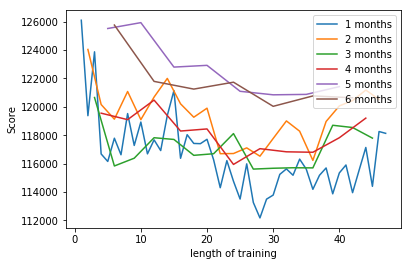

In [23]:
fig=plt.figure()
for j in range(1, 7):
    num_segment = int(total_months / j)
    x = [i*j for i in range(1, num_segment)]
    plt.plot(x, scores[j-1], label='{} months'.format(j))

plt.title('2008-01-01 ~ 2012-01-01')
plt.xlabel("length of training in months")
plt.ylabel("RMSE")
plt.legend()
plt.show()